# ALeRCE variable stars starter notebook

```Authors: Alejandra Muñoz Arancibia, Lorena Hernandez Garcia, Last updated: 20210406```

ALeRCE starter notebook for variable stars science using the alerce client, and a direct database connection.
For more information about the ALeRCE broker, please visit http://alerce.science/, or take a look to our presentation paper: Förster et al. 2021 (AJ accepted, https://arxiv.org/abs/2008.03303).

We provide a Python client for easier access to the ALeRCE API services. It can be installed via pip and is documented in https://alerce.readthedocs.io/en/latest/.

In [1]:
!pip install alerce

     |████████████████████████████████| 61kB 2.9MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Requirements <a class="anchor" id="req"></a>

In the following we specify the required packages to run this Notebook. Some of the packages are included in Python and others require installation. Uncomment in case you need to install.

Basic Requirements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Astropy and astroquery

In [3]:
!pip install astroquery

     |████████████████████████████████| 6.5MB 6.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 3.2MB 42.7MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp37-none-any.whl size=3831874 sha256=e4509c1478628eb18dbce89ed274362f8024daae0f8a5695e28167d6fbc65bab
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
Successfully built astroquery


In [4]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astroquery.irsa_dust import IrsaDust
from astroquery.simbad import Simbad

Install psycopg2 https://github.com/psycopg/psycopg2

In [5]:
#!pip install psycopg2-binary
import psycopg2

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Install P4J (https://pypi.org/project/P4J/). Note that this notebook uses a experimental version of P4J, which can be cloned and installed (python setup.py install --user) from https://github.com/phuijse/P4J/.

In [6]:
!pip install git+https://github.com/phuijse/P4J/
import P4J

  Cloning https://github.com/phuijse/P4J/ to /tmp/pip-req-build-o9ao6_4o
  Running command git clone -q https://github.com/phuijse/P4J/ /tmp/pip-req-build-o9ao6_4o
  Created wheel for P4J: filename=P4J-1.0.0-cp37-cp37m-linux_x86_64.whl size=1344683 sha256=be0fd39e5d433bf8d6fa634d2717e5d6489c86781cbbd2ae63a35fa35208549b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ft3f_4el/wheels/31/92/f9/82793ff4e2057ffad1e0bb6d6d155687878627ccf056008edf
Successfully built P4J


Other

In [7]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

# ALeRCE client <a class="anchor" id="client"></a>

To import the ALeRCE API client:

In [8]:
from alerce.core import Alerce
client = Alerce()

In [9]:
# color blind friendly green and red 
colors = {1: '#56E03A', 2: '#D42F4B'}

# Table of contents:
* [Introduction](#intro)
    * [Classifiers and taxonomies in ALeRCE](#classifiers)
* [Query one target](#onetarget)
    * [Light curve](#advancedlightcurve)
    * [Simple period](#simpleperiod)
    * [Show possible counterparts from SIMBAD](#crossmatch)
    * [Query image from Aladin](#crossmatch)
* [Query a sample of targets](#sampletarget)
    * [Examples on how to use the ALeRCE client and database](#examplesample)
        * [Using the ALeRCE client to query a larger sample of RRL](#clientrrl)
        * [Using the ALeRCE database (DB) to query a sample of RRL](#dbrrl)
            * [Query object computed features](#featuresrrl)

# Introduction <a class="anchor" id="intro"></a>

ALeRCE started to systematically classify the ZTF stream using machine learning with astrophysically motivated taxonomies
based on their light curves (Sánchez-Sáez et al. 2021, AJ, 161, 141, https://arxiv.org/abs/2008.03311) since March 2019, and on their image stamps (Carrasco-Davis et al. 2020, AJ submitted, https://arxiv.org/abs/2008.03309) since July 2019. These classfiers are designed to balance the needs for a fast and simple classification with a subsequent, but more complex classification.

The hierarchical taxonomy used by the ALeRCE broker for classifying light curves is shown in the figure below (v1.0.0). This classiffier uses four models: one which separates transients, stochastic and periodic objects; another which separates transients into SNe Ia, SNe Ib/c, SNe II and Superluminous SNe; another which separates stochastic objects into novae/CVs, blazars, QSOs, AGNs and YSOs; and another which classiffies periodic stars into LPVs, Ceph, RRL, DSCT, Es or Periodic-Other.
In total, the ALeRCE broker classifies objects into a taxonomy that has expanded into 15 classes, and with continuously improving precision and purity. Note that all of ALeRCE's data products can be accessed freely via several dashboards, APIs, or a direct database connection.

![taxonomy_tree](https://github.com/alercebroker/usecases/blob/master/notebooks/variablestars_figures/taxonomy_tree.png?raw=1)

## Classifiers and taxonomies in ALeRCE <a class="anchor" id="classifiers"></a>

There are two classifiers used in ALeRCE, and each of them has its own taxonomy, which is more refined for the light curve classifier.

1. A stamp based classifier (Carrasco-Davis et al. 2020), which classifies objects based on their first image stamps. The purpose of this classifier is to differentiate five different classes between Active Galactic Nucleus (AGN), Supernovae (SN), Variable Star (VS), Asteroid, or Bogus.

The stamp classifier contains the following classes (see the image in [Introduction](#intro)):

*    `AGN`
*    `SN`
*    `VS`
*    `asteroid`
*    `bogus`


2. A light curve based classifier (Sánchez-Sáez et al. 2021), which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band.
    
The light curve classifier uses the light curve information and contains the following classes (see the image in [Introduction](#intro)):

* `SNIa`
* `SNIbc`
* `SNII`
* `SLSN`
* `QSO`
* `AGN`
* `Blazar`
* `CV/Nova`
* `YSO`
* `LPV`
* `E`
* `DSCT`
* `RRL`
* `CEP`
* `Periodic-Other`

In particular, the light curve classifier considers the following classes of periodic variable stars:

- Long-Period Variable (LPV; includes regular, semi-regular, and irregular variable stars)

- RR Lyrae (RRL)

- Cepheid (CEP)

- Eclipsing binary (E)

- Delta Scuti (DSCT)

- Other periodic variable star (Periodic-Other; that includes classes of variable stars that are not well represented in the labeled set, e.g., sources classified as Hump, Misc, PCEB, Rotational, and RS CVn in CRTS).

And the following classes of stochastic variable stars:

- Young Stellar Objects (YSO)

- Nova/Cataclismic Variable (CV)

The confusion matrix from Sánchez-Saéz et al. (2021) shows that the light curve classifier has a very good performance separating periodic classes:

![SanchezSaez+2020_confusion](https://github.com/alercebroker/usecases/blob/master/notebooks/variablestars_figures/SanchezSaez+2020_confusion.png?raw=1)

In this notebook we will query data from a single variable star in order to plot its light curve, which can be corrected by extinction. Because these stars show periodic variability, we will plot their folded light curve and periodograms, thus we will be able to estimate their period. We will also see its image stamp, display posible counterparts from a public database, and visualize it in Aladin to explore its environment.

Then, we will show how to query a sample of variable stars using the ALeRCE client or the database (for big samples), showing their light curves and plotting different properties of the sample.

# Query one target <a class="anchor" id="onetarget"></a>

For this example, we selected a star classified as RR Lyrae in The Catalina Surveys RR Lyrae Data Release (http://nesssi.cacr.caltech.edu/DataRelease/RRL.html). The name of the star is V0420_Peg__ (CSS_J000018.2+193253 in the catalog). The RRL is located at RA = 00:00:18.200, DEC = +19:32:55.46.

Drake et al. (2013, ApJ, 763, 32) analyzed this survey, concentrated on the data taken by the Catalina Survey Schmidt 0.7m telescope (CSS) between April 2005 and June 2011, and reported the following properties for the star:

V magnitude = 15.664  mag

Period = 0.5454725 days (they find that the periods at generally accurate to sigma = 0.002%)

Amplitude = 0.85  mag

Number of points in the light curve = 211   

Distance = 9.73 kpc

Extinction = 0.088 mag

The name of this RRL in the ZTF is ZTF18abnznbm. Note that this light curve and the properties of this star can also be accessed through the Explorer: https://alerce.online/object/ZTF18abnznbm

In the following we will obtain and analyze the ZTF light curve of ZTF18abnznbm processed by the ALeRCE broker, and we will be able to compare the physical properties derived from this analysis with those already available in the literature.

## Light curve <a class="anchor" id="simplecurve"></a>

We start by manually defining the object identifier (oid) of the source we want to explore with the ALeRCE client:

In [10]:
seloid = "ZTF18abnznbm"

To obtain the apparent magnitude light curve (an estimate of the science images light curve), the ALeRCE pipeline sums up the flux measured in the difference images ($f_{\rm diff}$) and the flux measured from the template image ($f_{\rm ref}$), taking into account whether the difference between the science and reference image in a given epoch ($\rm sgn$) is positive or negative (for more details, see the appendix A in Förster et al. 2021):

$$
    \hat f_{\rm sci} = f_{\rm ref} + {\rm sgn}~ f_{\rm diff}
$$

We create a function to plot the light curve, that can be corrected for extinction using extinction mapping from a dictionary with attenuations due to Galactic extinction. Note that we use astroquery SIMBAD objects, as well as mag units.

In [11]:
def plotLCcorr(oid, VS_det, A=None):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    alpha=0.1, linestyle='None')
                # show dust attenuation corrected light curve
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr - A_fid, 
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid],
                    label="%s (ext. corr.)" % labels[fid], linestyle='None')
            else:
                # plot attenuated light curve
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    linestyle='None')
    
    # labels
    if A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)
        
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Then, we create a function that, given the object id (oid), gets the light curve data and plots the light curve if required, the results are then returned to the user as a dictionary. Note that we use the client to query the detections and that we return the results in pandas format (default is votable).
In particular, we can get the following information:


 - get the basic VS statistics, this includes the position in the sky (using the ALeRCE client)
 - get the detections (using the ALeRCE client)
 - get the dust attenuation at the given position in the sky (using astroquery IrsaDust)
 - get a cross-match with SIMBAD for a given search radius (using astroquery Simbad)
 - plot the apparent magnitude light curve corrected for dust attenuation (using the previously defined function)
 - plot the first image stamps associated to this VS (using the ALeRCE client)

In [12]:
def getVSdatacorr(oid, doLC=False, doext=False, dostamp=False, dosimbad=False, showlink=False):

    results = {"oid": oid}
    
    # query basic stats
    VS_stats = client.query_object(oid, format='pandas')
    results["stats"] = VS_stats
    
    # query magnitude stats
    VS_magstats = client.query_magstats(oid, format='pandas')
    results["magstats"] = VS_magstats
    
    # query detections
    VS_det = client.query_detections(oid, format='pandas')
    VS_det = VS_det.sort_values("mjd")
    results["lc_det"] = VS_det
        
    # object coordinates
    co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
                              frame='icrs')
    
    # get SIMBAD query
    if dosimbad:
        Simbad_table = Simbad.query_region(co, radius=0.01 * u.deg, equinox=2000)
        display(Simbad_table)
        results["simbad_table"] = Simbad_table
    
    # get Galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
             "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLCcorr(oid, VS_det, A)
        else:
            plotLCcorr(oid, VS_det)        
    
    if showlink:
        display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = client.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace=0, hspace=0)
        
    return results

And now we can show the light curve (without extinction corrections):

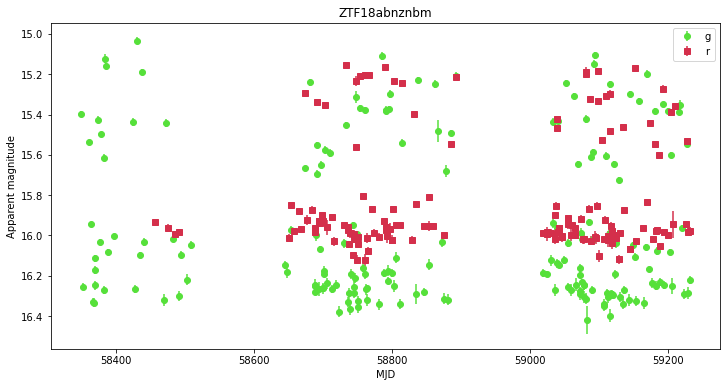

In [13]:
results = getVSdatacorr(seloid, doLC=True)

We can also plot the extinction corrected light curve, as well as the stamp and the link to the ALeRCE explorer:

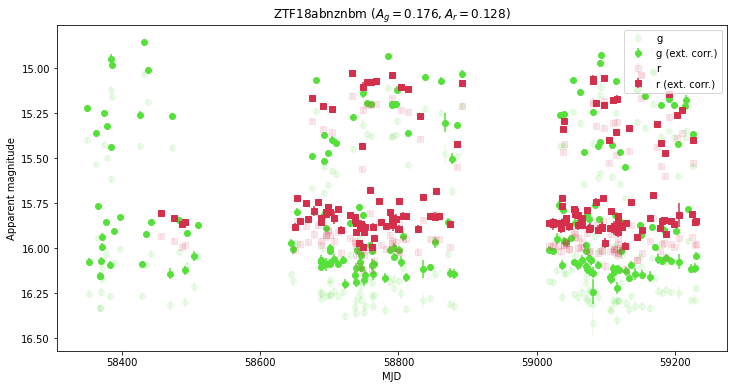

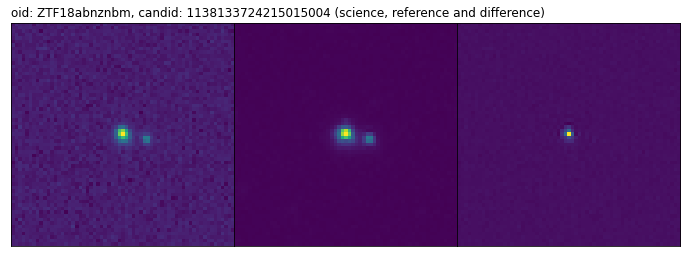

In [14]:
results = getVSdatacorr(seloid, doLC=True, doext=True, dostamp=True, showlink=True)

## Simple period <a class="anchor" id="simpleperiod"></a>

Because RRL are periodic objects, the light curve shown above is not too informative, thus we will plot the folded light curve and obtain three different periodograms, the multiband period, the period in the g filter, and in the r filter.

We will use P4J to calculate the periodograms (https://github.com/phuijse/P4J). P4J is a python package for period detection on irregularly sampled and heteroscedastic time series based on Information Theoretic objective functions. P4J was developed for astronomical light curves, irregularly sampled time series of stellar magnitude or flux. The core of the used package is a class called periodogram that sweeps an array of periods/frequencies looking for the one that maximizes a given criterion. The main contribution of this work is a criterion for period detection based on the maximization of Cauchy-Schwarz Quadratic Mutual Information (Huijse et al. 2018, ApJS, 236, 12). Information theoretic criteria incorporate information on the whole probability density function of the process and are more robust than classical second-order statistics based criteria (Principe 2010). For comparison P4J also incorporates other period detection methods used in astronomy such as the Phase Dispersion Minimization periodogram (Stellingwerf 1973), Lafler-Kinman's string length (Clarke 2002) and the Orthogonal multiharmonic Analysis of Variance periodogram (Schwarzenberg-Czerny 1996).

We will obtain the multiband period using the Multi Harmonic Analysis of Variance (MHAOV) periodogram (Mondrik et al. 2015, ApJL, 811, L34), using both g and r bands at the same time. We use this method since it provides a good trade-off between performance and computational complexity (see Sánchez-Sáez et al. 2021 for details), and for comparison purposes.

First we define the function to get the period of the star:

Note here that the user can modify the values of the parameters `fmin`, `fmax`, `fresolution` and `n_local_optima`.

In [15]:
def doperiod_multiband(VS_det, showperiod=False):
    
    mjds, mags, errs, fids = VS_det[["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T
    
    # Compute periodogram
    my_per = P4J.MultiBandPeriodogram(method='MHAOV')
    my_per.set_data(mjds, mags, errs, fids)        
    my_per.frequency_grid_evaluation(fmin=1e-3, fmax=20.0, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
    
    best_freq, best_per = my_per.get_best_frequencies()
    freq_mb, per_mb = my_per.get_periodogram()
    period_mb = 1.0 / best_freq[0]
    
    if showperiod:
        print('Multiband period: %.6f days' % period_mb)
    
    period = {}
    freq = {}
    per = {}
    labels = {1: 'g', 2: 'r'}
    
    for fid in [1, 2]:
        freq[fid], per[fid] = my_per.get_periodogram(fid)
        best_freq = my_per.get_best_frequency(fid)
        period[fid] = 1. / best_freq
        
        if showperiod:
            print("Period %s: %.6f days" % (labels[fid], period[fid]))
    
    return period_mb, freq_mb, per_mb, period, freq, per

Now define the function to be plotted:

In [16]:
def plotperiod_multiband(oid, VS_det, dofold=False, showperiodograms=False,
                         period_mb=None, freq_mb=None, per_mb=None,
                         period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}
    
    for idx, fid in enumerate([1, 2]):
        maskdet = VS_det.fid == fid
        
        if dofold:
            phase = np.mod(VS_det[maskdet].mjd, period_mb) / period_mb
            for nphase in [0, 1]:
                if nphase == 0:
                    label = labels[fid]
                else:
                    label = None
                ax.errorbar(phase + nphase, VS_det[maskdet].magpsf_corr, 
                        yerr = VS_det[maskdet].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=label,
                        markersize=5, linestyle='None')
        else:
            ax.errorbar(VS_det[maskdet].mjd, VS_det[maskdet].magpsf_corr, 
                    yerr=VS_det[maskdet].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    linestyle='None')
    
    if dofold:
        ax.set_title("%s (multiband period: %.6f days)" % (oid, period_mb))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    if dofold and showperiodograms:
        fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
        
        for idx, fid in enumerate([0, 1, 2]):
            if idx==0:
                ax[idx].plot(freq_mb, per_mb)
                ax[idx].set_title("Multiband periodogram")
                ax[idx].set_xlabel("frequency [1/days]")
            else:
                ax[idx].plot(freq[fid], per[fid])
                ax[idx].set_title("Periodogram %s (period: %.6f days)" % (labels[fid], period[fid]))
                ax[idx].set_xlabel("frequency [1/days]")

Get data, fold, and plot:

In [17]:
def getLCdata(oid, results, doplot=False, dofold=False, showperiod=False, showperiodograms=False):
    if dofold:
        # get period
        period_mb, freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"],
                                                                           showperiod=showperiod)
        results["period_multiband"] = period_mb
        results["period_band"] = period
    else:
        period = None; freq = None; per = None
        period_mb = None; freq_mb = None; per_mb = None
    
    if doplot:
        plotperiod_multiband(oid, results["lc_det"], dofold, showperiodograms,
                             period_mb=period_mb, freq_mb=freq_mb, per_mb=per_mb,
                             period=period, freq=freq, per=per)
        
    return results

We can plot the folded light curve and periodograms, and the respective periods are shown:

Multiband period: 0.545494 days
Period g: 0.545494 days
Period r: 0.545494 days


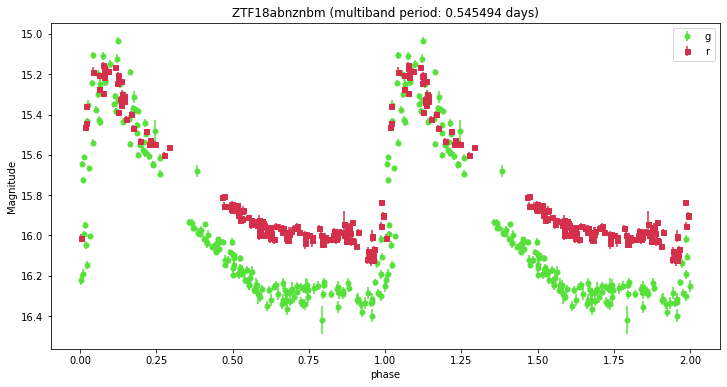

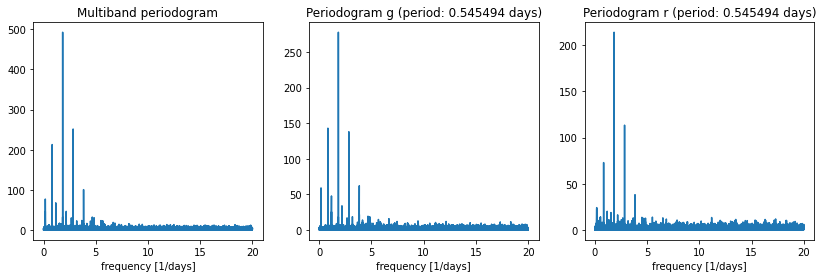

In [18]:
results = getVSdatacorr(seloid)
periodogram = getLCdata(seloid, results, doplot=True, dofold=True, showperiod=True, showperiodograms=True)

We estimated the period using the multiband periodogram, as well as individual periodograms for the filters g and r, and in all cases we obtained Period = 0.545494 days. If we compare with the work by Drake et al. (2013), they obtained Period = 0.5454725 days, thus in very good agreement. We can also check how does our light curve look adopting the period given by Drake et al. (2013):

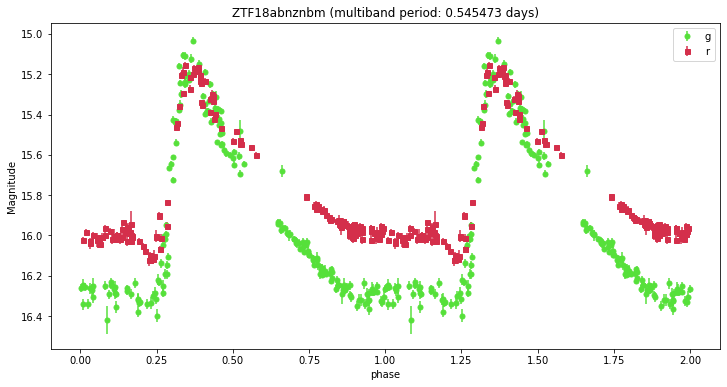

In [19]:
period_mb_test = 0.5454725
results = getVSdatacorr(seloid)
plotperiod_multiband(seloid, results["lc_det"], dofold=True, period_mb=period_mb_test)

This RRL is also present in ASAS-SN: https://asas-sn.osu.edu/variables/ebab1536-9eea-5846-8981-6937bc875eb2 which shows results in very good agreement with those reported here.

From our analysis, we can state that this is an ab-type RR Lyrae star, as noted by its typical sawtooth-shaped light curve, period of order half a day, fast rise time (time between minimum and maximum), and shock-related bump before minimum light. 
Note that the color (g-r) can be directly inferred from the g and r light curves. The resulting values are typical of an RR Lyrae star that is not heavily affected by extinction, and which changes smoothly as a function of phase, as expected for this class of pulsating stars.

## Show possible counterparts from SIMBAD <a class="anchor" id="crossmatch"></a>

We can display a table with cross-match(es) in the SIMBAD public database for our adopted search radius (0.01 deg).

In [20]:
results = getVSdatacorr(seloid, dosimbad=True)

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
V* V420 Peg,00 00 18.1975,+19 32 55.448,14,14,0.051,0.024,90,A,O,2018yCat.1345....0G


## Query image from Aladin <a class="anchor" id="crossmatch"></a>

We can show an image from Aladin to see the star and its environment from a PanSTARRS DR1 image.

In [21]:
def show_image(results):
    query = """
<!-- include Aladin Lite CSS file in the head section of your page -->
<link rel="stylesheet" href="https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.css" />
 
<!-- you can skip the following line if your page already integrates the jQuery library -->
<script type="text/javascript" src="https://code.jquery.com/jquery-1.12.1.min.js" charset="utf-8"></script>
 
<!-- insert this snippet where you want Aladin Lite viewer to appear and after the loading of jQuery -->
<div id="aladin-lite-div" style="width:800px;height:400px;"></div>
<script type="text/javascript" src="https://aladin.u-strasbg.fr/AladinLite/api/v2/latest/aladin.min.js" charset="utf-8"></script>
<script type="text/javascript">
    var aladin = A.aladin('#aladin-lite-div', {survey: "P/PanSTARRS/DR1/color-z-zg-g", fov:0.04, target: "%s, %s"});
</script>
""" % (float(results["stats"].meanra), float(results["stats"].meandec))
    display(HTML(query))
    #print(query)

In [22]:
results = getVSdatacorr(seloid)
show_image(results)

# Query a sample of targets <a class="anchor" id="sampletarget"></a>

As explained in the [Introduction](#intro), ALeRCE systematically classifies the sources into a hierarchical [taxonomy](#classifiers), based on a stamp classifier which classifies in five subclasses, and a light curve classifier that is used when at least six detections are obtained in the light curve, which provides a more detailed classification up to 15 classes. In this part of the notebook we will show examples using the ALeRCE client and the database to query different samples of variable stars.

## Examples on how to use the ALeRCE client and database<a class="anchor" id="examplesample"></a>

In the following, we will explore three different options to query data from ALeRCE:


- [Using the ALeRCE client to query a sample of RRL](#clientrrl)

- [Using the ALeRCE database (DB) to query a sample of RRL. Note that the DB allows more complex queries](#dbrrl)

### Using the ALeRCE client to query a sample of RRL <a class="anchor" id="clientrrl"></a>

In this example we will access the ALeRCE client to do a simple query to get information about a sample of 100 targets first detected at least 100 days after ZTF's 1st light, with a probability of being classified as RRL by the light curve classifier larger than 0.8, with a minimum of 100 detections, that will be ordered by their probability. We will output the result of the query directly as a pandas dataframe:

In [23]:
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 100

VSs = client.query_objects(classifier="lc_classifier",
                           class_name="RRL", 
                           probability=0.8,
                           ndet=[100,None],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           count=False,
                           page_size=100, format='pandas')
print(VSs.shape)
VSs.head()

(100, 23)


,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,g_r_mean_corr,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF17aaadoqd,181,336,58274.356319,59190.114768,True,True,148,-0.358578,-0.046480,-0.121367,0.250028,58349.209965,59190.114768,840.904803,313.176026,-1.164794,0.000040,0.000052,RRL,lc_classifier,0.937008,corr_bulk_0.0.1
1,ZTF18abvwpht,210,311,58305.398461,59188.093345,True,True,142,-0.470036,-0.082203,0.074167,0.177482,58375.282083,59188.093345,812.811262,313.335708,-7.730580,0.000045,0.000049,RRL,lc_classifier,0.919680,corr_bulk_0.0.1
2,ZTF17aabwvyk,282,566,58333.359618,59218.132407,True,True,161,-0.732367,-0.151859,-0.069006,0.159725,58351.403310,59218.132407,866.729097,345.198407,6.282067,0.000057,0.000069,RRL,lc_classifier,0.915848,corr_bulk_0.0.1
3,ZTF18acsvnpf,214,345,58303.377442,59204.127222,True,True,136,-0.533981,-0.121360,0.142076,0.103969,58456.068426,59204.127222,748.058796,329.346451,-11.588441,0.000054,0.000053,RRL,lc_classifier,0.913900,corr_bulk_0.0.1
4,ZTF18abtjpzd,203,390,58305.398461,59186.094063,True,True,141,-0.605967,-0.063493,0.019688,0.154505,58366.315683,59186.094063,819.778380,312.517945,-8.409144,0.000043,0.000051,RRL,lc_classifier,0.913872,corr_bulk_0.0.1


For example we can make an histogram of the number of detections for the sample:

Text(0.5, 0, 'N. detections')

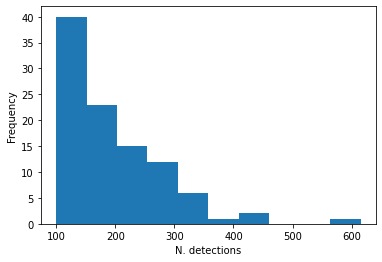

In [24]:
fig, ax = plt.subplots()
VSs.ndet.plot.hist(ax=ax)
ax.set_xlabel("N. detections")

We define a function to plot different properties of the stars:

In [25]:
def plot_properties(propx, propy, propx_label, propy_label, dodiag=False):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(propx, propy, alpha=0.5)
    ax.set_xlabel("%s" % propx_label)
    ax.set_ylabel("%s" % propy_label)
    
    if dodiag:
        t = np.arange(min(propx)-0.1, max(propx)+0.1, 0.01)
        s = t
        ax.plot(t, s,color='gray', linestyle='--',label="y=x")
        ax.legend()

For example, we can plot their mean corrected colors, g_r_mean_corr, versus their maximum corrected colors, g_r_max_corr:

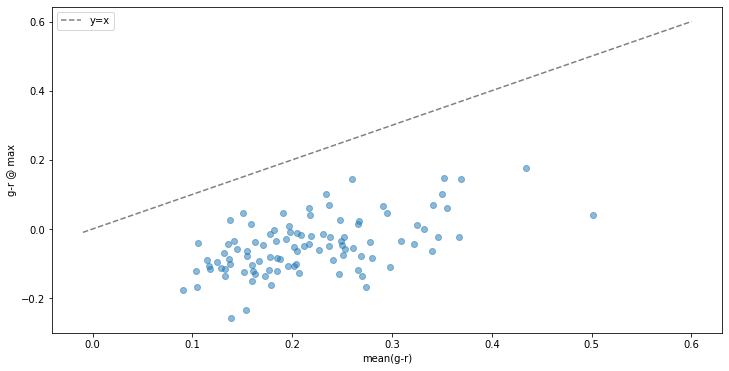

In [26]:
plot_properties(propx=VSs.g_r_mean_corr, propy=VSs.g_r_max_corr,
                propx_label="mean(g-r)", propy_label="g-r @ max", dodiag=True)

As expected, the maximum colors are bluer that the mean values. This is because the stars move in diagonal loops in color-magnitude plots.


### Using the ALeRCE database (DB) to query a sample of RRL <a class="anchor" id="dbrrl"></a>

The previous way of querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here. You will need to use the read only credentials available in the repository

In [27]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

Now we open a connection to the DB

In [28]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

And we show all the available tables

In [29]:
query = """
SELECT table_name FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="table_name")

,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version
5,gaia_ztf
6,lc_classifier
7,lc_classifier_periodic
8,lc_classifier_stochastic
9,lc_classifier_top


You can see all the tables used in the new version of our database. The most relevant tables are, moving from less to more aggregation:

* `non_detection`: one row per non-detection per object, the limiting magnitudes
* `detections`: one row per detection, light curves and other relevant time dependent information
* `dataquality`: one row per detection, data quality related time dependent information
* `magstat`: one row per object per filter, statistics per bandpass per object
* `object`: one row per object, basic object statistics
* `probability`: one row per object per classifier and class, the probabilities of every object
* `reference`: one row per object per reference image, object statistics for every reference image used
* `feature`: one row per object per feature, object computed features
* `xmatch`: one row per object per external catalog, the table that points to the detailed xmatch tables
* `allwise, ps1_ztf, gaia_ztf, ss_stf`: one row per object, xmatch tables


For completeness, we now show all columns available in all tables:

In [30]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101



,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


Now we can do a query asking for RRL candidates. For this it is important to understand the `probability` table. This table contains all the classifications probabilities, for every object, every classifier, and every available class. An object will be in many rows of this table, with the idea of being flexible to future changes in the taxonomy.

For example, an object classified by the light curve classifier (classifier_name = lc_classifier) will appear in all the available classes, e.g., class_name = 'SNIa' or class_name = 'AGN', independently of whether this is the most likely class. The most likely class can be quickly obtained with the ranking column (ranking = 1). For example, if we want to find the probabilities of the objects most likely to be RR Lyrae, we would look for objects with classifier_name = 'lc_classifier', class_name = 'RRL' and ranking = 1. The probabilities will be given by the probability column.

We will query objects that are most likely to be RRL with a probability larger than 0.55 and have 100 or more detections. For this we will do a complex query, including an inner join between object and probability.

In [31]:
query='''
SELECT
    object.oid, object.meanra, object.meandec, object.ndet,
    object.firstMJD, object.deltajd, object.g_r_max,
    probability.classifier_name, probability.class_name,
    probability.ranking, probability.probability
FROM
    object INNER JOIN probability
    ON object.oid = probability.oid
WHERE
    probability.classifier_name = 'lc_classifier'
    AND probability.class_name IN ('RRL')
    AND probability.ranking = 1
    AND probability.probability > 0.55
    AND object.ndet >= 100
'''

rrl_sample = pd.read_sql_query(query, conn)
print(rrl_sample.shape)
rrl_sample.set_index('oid', inplace=True)
rrl_sample.head(10)

(14823, 11)


,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability
oid,,,,,,,,,,
ZTF18aaajenf,174.941157,15.794535,224,58258.206724,1049.071007,0.262933,lc_classifier,RRL,1,0.550024
ZTF17aaarqcg,32.910534,-11.202156,122,58365.439549,890.709271,-0.587400,lc_classifier,RRL,1,0.550128
ZTF17aabowfg,330.712946,36.099635,263,58351.408009,958.104074,-0.172728,lc_classifier,RRL,1,0.550128
ZTF18aaybsfm,242.629575,11.040569,167,58274.293681,1034.086424,-0.088782,lc_classifier,RRL,1,0.550128
ZTF17aaarxcm,63.055905,77.868521,245,58375.455868,930.743391,-0.336003,lc_classifier,RRL,1,0.550128
ZTF17aabxkoz,211.437661,28.537293,188,58279.238403,1030.152824,-0.108849,lc_classifier,RRL,1,0.550128
ZTF18abadqnb,334.748965,52.640240,226,58281.434861,950.701794,-0.193483,lc_classifier,RRL,1,0.550800
ZTF18abodevs,8.459911,16.786416,253,58352.463322,903.669641,-0.129900,lc_classifier,RRL,1,0.550128
ZTF18aboacji,251.457117,9.185088,180,58350.145984,957.337014,-0.153353,lc_classifier,RRL,1,0.550848


Now we plot an histogram of the source probabilities of being finally classified as RRL:

Text(0, 0.5, 'Frequency')

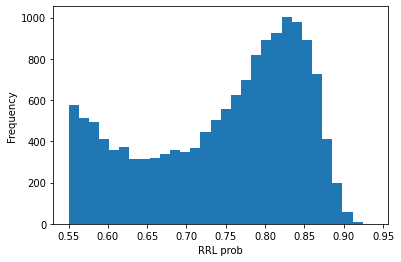

In [32]:
fig, ax = plt.subplots()
ax.hist(rrl_sample.probability, bins=30)
ax.set_xlabel("RRL prob")
ax.set_ylabel("Frequency")

#### Query object computed features<a class="anchor" id="features"></a>

Computing the amplitude from the detection magnitudes and the multiband period in the way shown previously can be time consuming for a large sample of sources; the light curve classifier uses variability features computed from the ZTF alert stream. Two relevant features are `Multiband_period`, which is a period obtained using the MHAOV periodogram mentioned before, and `Amplitude`, which is defined as the half of the difference between the median of the maximum 5 percent and the median of the minimum 5 percent magnitudes (then we use twice the obtained value as the light curve amplitude). Let's query the feature names from the `feature` table.

In [33]:
rrl_oids = rrl_sample.index.values

query='''
SELECT
    *
FROM
    feature
WHERE
    (name='Amplitude'
    OR name='Multiband_period')
    AND oid in (%s)
''' % ",".join(["'%s'" % oid for oid in rrl_oids])

rrl_features = pd.read_sql_query(query, conn)
rrl_features.set_index('oid', inplace=True)
rrl_features.head()

,name,value,fid,version
oid,,,,
ZTF17aaaaaya,Amplitude,0.523865,1,feature_0.0.1
ZTF17aaaaaya,Amplitude,0.365857,2,feature_0.0.1
ZTF17aaaaaya,Multiband_period,0.566604,12,feature_0.0.1
ZTF17aaaabhx,Amplitude,0.639678,1,feature_0.0.1
ZTF17aaaabhx,Amplitude,0.417650,2,feature_0.0.1


With these features we can plot the amplitude for each filter as a function of the multiband period:

In [34]:
mask = rrl_features.name == "Multiband_period"
rrl_period_mb = rrl_features.loc[mask]

mask = (rrl_features.name == "Amplitude") & (rrl_features.fid==1)
rrl_amplitude_g = rrl_features.loc[mask]

mask = (rrl_features.name == "Amplitude") & (rrl_features.fid==2)
rrl_amplitude_r = rrl_features.loc[mask]

Text(0, 0.5, 'Amplitude (mag)')

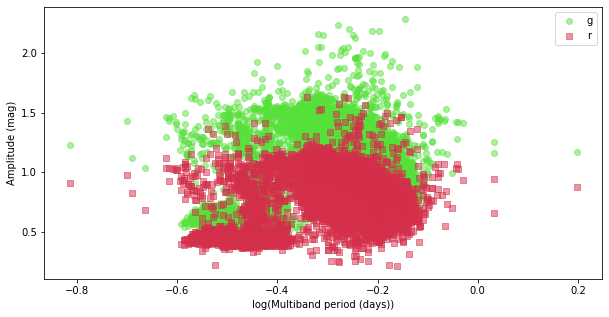

In [35]:
labels = {1: 'g', 2: 'r'}
markers = {1: 'o', 2: 's'}

fig, ax = plt.subplots(figsize = (10, 5))

for fid in [1, 2]:
    if fid==1:
        amplitude = rrl_amplitude_g.value*2.
    else:
        amplitude = rrl_amplitude_r.value*2.
    
    ax.scatter(np.log10(rrl_period_mb.value), amplitude, c=colors[fid], marker=markers[fid],
               label=labels[fid], alpha=0.5)

ax.legend()
ax.set_xlabel("log(Multiband period (days))")
ax.set_ylabel("Amplitude (mag)")

From our plot we can distinguish two RRL sub-populations, namely ab-type and c-type RRL, which lie around log(multiband period) values of -0.25 and -0.5, respectively. As mentioned previously, note that the number of sources classified as ab-type RRL is far larger than that of c-type RRL. For details see Sánchez-Sáez et al. (2021).

We can now display example light curves for each sub-population, taking e.g. the source with the (current) largest number of detections and log(multiband period) around the values mentioned before. First we gather the data in a pandas dataframe, and create subsets of sources for given log(multiband period) intervals:

In [36]:
rrl_period_mb = rrl_period_mb.drop(columns=['name', 'fid', 'version'])
rrl_period_mb.rename(columns={'value': 'Multiband_period'}, inplace=True)
rrl_amplitude_g = rrl_amplitude_g.drop(columns=['name', 'fid', 'version'])
rrl_amplitude_g.rename(columns={'value': 'Amplitude_g'}, inplace=True)
rrl_amplitude_r = rrl_amplitude_r.drop(columns=['name', 'fid', 'version'])
rrl_amplitude_r.rename(columns={'value': 'Amplitude_r'}, inplace=True)
rrl_sample_features = pd.concat([rrl_sample, rrl_period_mb, rrl_amplitude_g, rrl_amplitude_r],
                                axis=1, sort=True)
rrl_sample_features.head()

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability,Multiband_period,Amplitude_g,Amplitude_r
ZTF17aaaaaya,326.800433,49.066387,518,58277.450602,954.685590,0.308760,lc_classifier,RRL,1,0.573104,0.566604,0.523865,0.365857
ZTF17aaaabhx,76.596246,53.758432,439,58345.429410,964.749676,0.227606,lc_classifier,RRL,1,0.637416,0.592242,0.639678,0.417650
ZTF17aaaabtj,30.542630,32.079499,261,58361.451007,912.721551,-0.104700,lc_classifier,RRL,1,0.556308,0.325850,0.294114,0.208779
ZTF17aaaadgd,54.010452,1.561411,190,58450.414491,829.755683,-0.420796,lc_classifier,RRL,1,0.713012,0.464706,0.759756,0.557304
ZTF17aaaaeti,30.542627,32.079500,265,58361.451007,914.705428,-0.104618,lc_classifier,RRL,1,0.564880,0.325850,0.293546,0.208786


In [37]:
rrlab_logperiod_typical = -0.25
rrlc_logperiod_typical = -0.5
delta_logperiod = 0.02

rrlab = rrl_sample_features[:][(np.log10(rrl_sample_features.Multiband_period)>rrlab_logperiod_typical-delta_logperiod) &
    (np.log10(rrl_sample_features.Multiband_period)<rrlab_logperiod_typical+delta_logperiod)]

rrlc = rrl_sample_features[:][(np.log10(rrl_sample_features.Multiband_period)>rrlc_logperiod_typical-delta_logperiod) &
    (np.log10(rrl_sample_features.Multiband_period)<rrlc_logperiod_typical+delta_logperiod)]

Now we find the identifiers of the sources having the largest number of detections in each subset, and plot their folded light curves:

In [38]:
oid_rrlab_example = rrlab.ndet.idxmax()
oid_rrlc_example = rrlc.ndet.idxmax()
seloid = [oid_rrlab_example, oid_rrlc_example]

rrl_sample_features.loc[seloid].head()

,meanra,meandec,ndet,firstmjd,deltajd,g_r_max,classifier_name,class_name,ranking,probability,Multiband_period,Amplitude_g,Amplitude_r
ZTF17aaaecwh,340.560324,51.300518,1771,58272.466192,1038.046296,-0.24789,lc_classifier,RRL,1,0.787072,0.579307,0.517271,0.370632
ZTF18aarkchp,293.786306,60.520148,798,58245.452951,1064.983623,-0.27442,lc_classifier,RRL,1,0.559048,0.311100,0.288611,0.198865


/usr/local/lib/python3.7/dist-packages/P4J/periodograms.py:64: RuntimeWarning: invalid value encountered in true_divide
  per_single_band.update({filter_name : (d2/d1)*per/(self.cython_per[filter_name].wvar-per)})


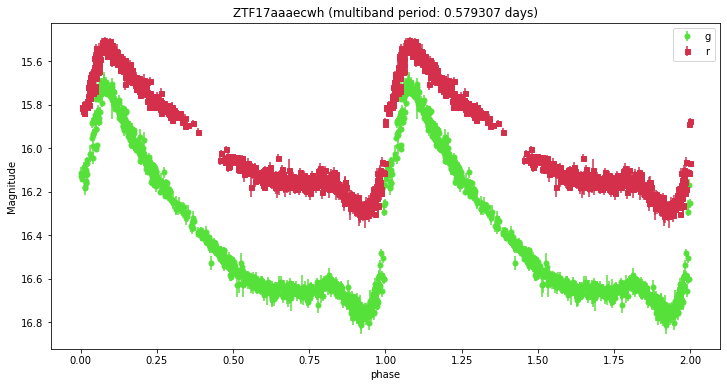

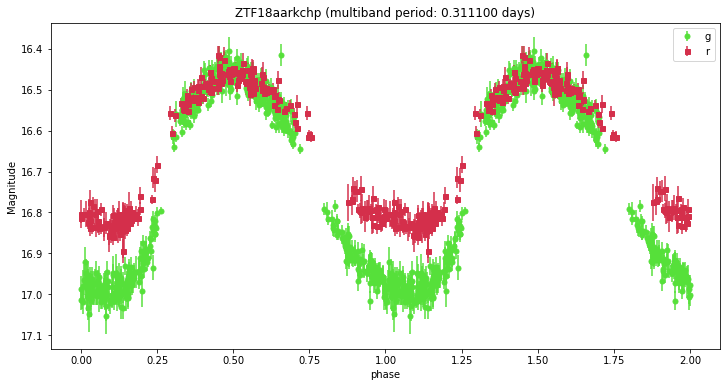

In [39]:
for oid in seloid:
    results = getVSdatacorr(oid)
    periodogram = getLCdata(oid, results, doplot=True, dofold=True)

Finally, we close the connection to the DB:

In [40]:
conn.close()

An extended version of this notebook can be found in https://github.com/alercebroker/usecases/blob/master/notebooks/ALeRCE_ZTF_VariableStars.ipynb.